# G47301 - UWGeodynamics v2.8.5 - notebook repository

# Strain and retrogression partitioning explain long-term stability of crustal roots in stable continents: Cenki-Tok, Rey and Arcay

The following notebook reproduces the numerical model presented in Cenki-Tok et al, 2020. This notebook has been strongly modified from "Tutorial_2_Melt.ipynb" by R. Beucher. More info on the code used under https://github.com/underworldcode/UWGeodynamics and https://www.underworldcode.org.

Cenki-Tok, B., Rey, P. F., Arcay, D. (2020). Strain and retrogression partitioning explain long-term stability of crustal roots in stable continents. Geology


In [1]:
import matplotlib.pyplot as plt
import UWGeodynamics as GEO
import underworld as uw
import underworld.function as fn
from UWGeodynamics.surfaceProcesses import SedimentationThreshold
import numpy as np
import scipy
import os.path
from mpi4py import MPI
import argparse
import glucifer

loaded rc file /usr/local/lib/python3.5/dist-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
GEO.__version__

'2.8.5'

# Working with units

Note that this is not an obligation and you can use values without units 


The geodynamics module enables usage of a broad range of units using a *UnitRegistry*. You can attach a unit to any value that you need to define. A value with a units attached becomes a *Quantity* python object. The geodynamics module take care of the conversion internally so you may use any units that you think are appropriate. You can also mix them.

The module will also try to work out a scaling of the values to help the computation process. The user can chose to alter the way his or her values are scaled or can rely on the default options.

To use the units system, you can link the unit registry as follow:

In [3]:
u = GEO.UnitRegistry

## Scaling

In [4]:
resolution = (240,80)
half_rate = 18 * u.millimeter / u.year
model_length = 360e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3370 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

# Model setup

The starting model is 360 km long and 120 km thick, and includes 15 km of air-like material (low density, low viscosity) and a 70 km thick crust above 35 km of upper mantle. A weak prismatic region dipping 45° simulates a detachment fault in the upper crust.

In [5]:
Model = GEO.Model(elementRes=resolution, 
                  minCoord=(0. * u.kilometer, -105. * u.kilometer), 
                  maxCoord=(360. * u.kilometer, 15. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [6]:
Model.outputDir="outputs_script-G47301-Cenki-Tok-etal_test4"

For all rocks, we assume a heat capacity of 1000 J kg−1 K−1 and thermal diffusivity of 9·10−7 m2 s−1. The crustal thermal conductivity is therefore 2.45 W m−1 K−1.

In [7]:
Model.diffusivity = 9e-7 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

### Air Layer

In [8]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0 * u.kilometer))
air.density = 1. * u.kilogram / u.metre**3
air.diffusivity = 1e-6 * u.metre**2 / u.second
air.capacity = 1000. * u.joule / (u.kelvin * u.kilogram)

### Continental Crust

Because the composition of the continental crust changes with depth,
an increase in density is expected toward the Moho. The continental crust can become granulitic under specific Temperature and strain rate conditions (see below). The reference density for the continental crust is 2600 kg.m−3 and the granulitic continental crust is 2950 kg.m−3. The corresponding thermal expansivity and compressibility for the crust are 1e-4 K-1 and 8e-11 Pa-1, respectively. We consider that the average continental crust has a radiogenic heat production of 5e-7 W.m-3. 

In [9]:
continentalcrust = Model.add_material(name="Continental Crust", shape=GEO.shapes.Layer(top=0. * u.kilometer, bottom=-70. * u.kilometer))
continentalcrust.radiogenicHeatProd = 5e-7 * u.watt / u.meter**3
continentalcrust.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3,
                                              thermalExpansivity = -10e-5 * u.kelvin**-1,
                                              beta               = 80e-12 * u.pascal**-1)

In [10]:
retrogressedcontinentalcrust = Model.add_material(name="Retrogressed Continental Crust")
retrogressedcontinentalcrust.radiogenicHeatProd = 5e-7 * u.watt / u.meter**3
retrogressedcontinentalcrust.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3,
                                              thermalExpansivity = -10e-5 * u.kelvin**-1,
                                              beta               = 80e-12 * u.pascal**-1)

In [11]:
granuliticcontinentalcrust = Model.add_material(name="Granulite Continental Crust")
granuliticcontinentalcrust.radiogenicHeatProd = 5e-7 * u.watt / u.meter**3
granuliticcontinentalcrust.density  = GEO.LinearDensity(reference_density  = 2950. * u.kilogram / u.metre**3,
                                              thermalExpansivity = -10e-5 * u.kelvin**-1,
                                              beta               = 80e-12 * u.pascal**-1)

### Upper-Mantle

At room conditions, the density of the mantle is 3370kgm−3 and has a coefficient of thermal expansion of 2.8·10−5 K−1

In [12]:
uppermantle = Model.add_material(name="Upper Mantle", shape=GEO.shapes.Layer(top=-70. * u.kilometer, bottom=Model.bottom))
uppermantle.density = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3,
                                        thermalExpansivity= 2.8e-5 * u.kelvin**-1)

### Fault

In [13]:
vertices = [(169.  * u.kilometer,  0. * u.kilometer),
            (172. * u.kilometer,   0. * u.kilometer),
            (191. * u.kilometer, -20. * u.kilometer),
            (188. * u.kilometer, -20. * u.kilometer)]

fault = Model.add_material(name="Fault", shape=GEO.shapes.Polygon(vertices))
fault.density = 2600. * u.kilogram / u.metre**3
fault.radiogenicHeatProd = 5e-7 * u.watt / u.meter**3


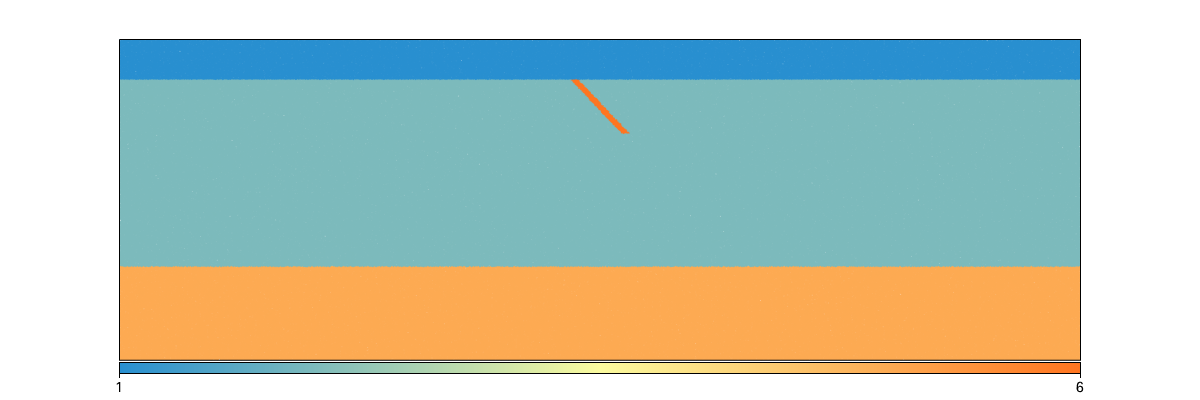

In [14]:
FigMat = glucifer.Figure(figsize=(1200,400))
FigMat.Points(Model.swarm, Model.materialField, fn_size=2.0)
FigMat.show()

# Define Viscosities

The crust and the mantle have a visco-plastic rheology with a
temperature and stress dependent viscosity for stresses below the yield stress,
and a depth dependent plastic branch above it.
We use power law relationships between strain rate and stress
to describe dislocation creep. 

The viscosity varies with the temperature and stress according to:

crust, A, n and Q are those of quartz-rich rock (pre-exponent Ac=5·10−6 MPa−nc
s−1, nc=3, Qc=1.9·10e5 Jmol−1, Goetze,
1978). The pre-exponent factor for the fault is 0.1 which makes the fault ten times less viscous than the crust in which it is embedded. The rheology of granulitic continental crust is from Mackwell et al., 1998 (pre-exponent Ac=5.05·10−22 MPa−nc s−1, nc=4.7, Qc=4.85·10e5 Jmol−1). The rheology of the mantle is that of dry olivine (pre-exponent Am= 7·10e4 MPa−nm
s−1, nm=3, Qm=5.2·10e5 J mol−1, Brace and Kohlstedt,
1980). 

In [15]:
rh = GEO.ViscousCreepRegistry()

Model.minViscosity = 1e18 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second

air.viscosity = 5e18 * u.pascal * u.second
continentalcrust.viscosity = rh.Wet_Quartz_Dislocation_Paterson_and_Luan_1990
retrogressedcontinentalcrust.viscosity = rh.Wet_Quartz_Dislocation_Paterson_and_Luan_1990
granuliticcontinentalcrust.viscosity = rh.Dry_Maryland_Diabase_Dislocation_Mackwell_et_al_1998
uppermantle.viscosity = rh.Wet_Dunite_Dislocation_Brace_and_Kohlstedt_1980
fault.viscosity = 0.1 * rh.Wet_Quartz_Dislocation_Paterson_and_Luan_1990

In [16]:
continentalcrust.viscosity = GEO.ViscousCreep(
    name=None,
    preExponentialFactor=5.0e-6 / u.megapascal**3 / u.second,
    stressExponent=3.0,
    activationVolume=0.0,
    activationEnergy=190000.0 * u.joule / u.mole,
    waterFugacity=None,
    grainSize=None,
    meltFraction=None,
    grainSizeExponent=0.0,
    waterFugacityExponent=0.0,
    meltFractionFactor=0.0,
    f=1.0,
    mineral="unspecified",
    creep_type="unspecified",
)

In [18]:
retrogressedcontinentalcrust.viscosity = GEO.ViscousCreep(
    name=None,
    preExponentialFactor=5.0e-6 / u.megapascal**3 / u.second,
    stressExponent=3.0,
    activationVolume=0.0,
    activationEnergy=190000.0 * u.joule / u.mole,
    waterFugacity=None,
    grainSize=None,
    meltFraction=None,
    grainSizeExponent=0.0,
    waterFugacityExponent=0.0,
    meltFractionFactor=0.0,
    f=1.0,
    mineral="unspecified",
    creep_type="unspecified",
)

In [20]:
fault.viscosity = GEO.ViscousCreep(
    name=None,
    preExponentialFactor=5.0e-6 / u.megapascal**3 / u.second,
    stressExponent=3.0,
    activationVolume=0.0,
    activationEnergy=190000.0 * u.joule / u.mole,
    waterFugacity=None,
    grainSize=None,
    meltFraction=None,
    grainSizeExponent=0.0,
    waterFugacityExponent=0.0,
    meltFractionFactor=0.0,
    f=0.1,
    mineral="unspecified",
    creep_type="unspecified",
)

In the crust and the mantle, frictional sliding is modeled via a Mohr
Coulomb criterion with a cohesion (C0) of 15 MPa and a coefficient of friction (µ) of 0.44. 
The cohesion and coefficient of internal friction in the fault are C0/10 and µ/10, respectively.
In all material, the yield stress linearly drops to a maximum of 20% of its initial value when the accumulated strain reaches 0.5 (cf.Wijns et al., 2005 for details). For differential stresses reaching the yield stress, the material fails and deformation is modeled by an effective viscosity: ηyield=τyield/(2 · E) in which E is the second invariant of the strain rate tensor. 

In [ ]:
continentalcrust.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                                cohesion=15. * u.megapascal,
                                                cohesionAfterSoftening=3. * u.megapascal,
                                                frictionCoefficient=0.44,
                                                frictionAfterSoftening=0.088,
                                                epsilon1=0.0, epsilon2=0.5)

retrogressedcontinentalcrust.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                                cohesion=15. * u.megapascal,
                                                cohesionAfterSoftening=3. * u.megapascal,
                                                frictionCoefficient=0.44,
                                                frictionAfterSoftening=0.088,
                                                epsilon1=0.0, epsilon2=0.5)

granuliticcontinentalcrust.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                                cohesion=15. * u.megapascal,
                                                cohesionAfterSoftening=3. * u.megapascal,
                                                frictionCoefficient=0.44,
                                                frictionAfterSoftening=0.088,
                                                epsilon1=0.0, epsilon2=0.5)

uppermantle.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                           cohesion=15. * u.megapascal,
                                           cohesionAfterSoftening=3. * u.megapascal,
                                           frictionCoefficient=0.44,
                                           frictionAfterSoftening=0.088,
                                           epsilon1=0.0, epsilon2=0.5)

fault.plasticity = GEO.DruckerPrager(name="Fault", 
                                     cohesion=1.5 * u.megapascal,
                                     cohesionAfterSoftening=0.3 * u.megapascal,
                                     frictionCoefficient=0.44,
                                     frictionAfterSoftening=0.088,
                                     epsilon1=0.0, epsilon2=0.5)

## Melt

In [ ]:
solidii = GEO.SolidusRegistry()
#crust_solidus = solidii.Crustal_Solidus
my_crust_solidus = GEO.Solidus(A1=923 * u.kelvin, A2=-1.2e-07 * u.kelvin / u.pascal, A3=1.2e-16 * u.kelvin / u.pascal**2, A4=0.0 * u.kelvin / u.pascal**3)
mid_crust_solidus = solidii.Mid_Crustal_Solidus

liquidii = GEO.LiquidusRegistry()
#crust_liquidus = liquidii.Crustal_Liquidus
my_crust_liquidus = GEO.Liquidus(A1=1423 * u.kelvin, A2=-1.2e-07 * u.kelvin / u.pascal, A3=1.6e-16 * u.kelvin / u.pascal**2, A4=0.0 * u.kelvin / u.pascal**3)
mid_crust_liquidus = liquidii.Mid_Crustal_Liquidus

In our experiments, the viscosity decreases linearly by 3 orders of magnitude when the melt fraction increases from 15 to 30%. When the melt fraction is 15%, the viscosity of the melted crust is that of the non-melted surrounding; when the melt fraction is 30%, its viscosity is a thousand times lower than in surrounding material. Rosenberg and Handy (2005) showed that significant weakening occurs at 7% melt fraction.

In [ ]:
continentalcrust.add_melt_modifier(my_crust_solidus, my_crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )  

retrogressedcontinentalcrust.add_melt_modifier(my_crust_solidus, my_crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        ) 

fault.add_melt_modifier(my_crust_solidus, my_crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )

granuliticcontinentalcrust.add_melt_modifier(mid_crust_solidus, mid_crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )  


## Temperature Boundary Condition
The geotherm is based on a constant heat flow imposed at the base of the model (0.022 W m−2), a constant temperature imposed at the top (20 °C).

In [ ]:
Model.set_temperatureBCs(top=293.15 * u.degK, materials=[(air, 293.15*u.degK)])

In [ ]:
Model.set_heatFlowBCs(bottom=(0.015 * u.watt / u.metre**2, uppermantle))

## Velocity Boundary Conditions

In [ ]:
Model.set_velocityBCs(left=[-1.8 * u.centimeter / u.year, None],
                       right=[1.8 * u.centimeter / u.year, None],
                       bottom=GEO.LecodeIsostasy(reference_mat=uppermantle, average=True))

## Interface Tracers

In [ ]:
x = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), 1000)
y = 0.

surface_tracers = Model.add_passive_tracers(name="Surface", vertices=[x,y])
moho_tracers = Model.add_passive_tracers(name="Moho", vertices=[x,y-GEO.nd(70.*u.kilometer)])

## Grid Tracers

In [ ]:
x_c, y_c = GEO.circles_grid(radius=2.0*u.kilometer, 
                    minCoord=[Model.minCoord[0], continentalcrust.bottom], 
                    maxCoord=[Model.maxCoord[0], 0.*u.kilometer])

FSE_Crust = Model.add_passive_tracers(name="FSE_Crust", vertices=[x_c, y_c])

## Run Model

In [ ]:
Model.init_model()

In [ ]:
Model.bottom

-105.0 <Unit('kilometer')>

In [ ]:
GEO.nd(500*u.kelvin)

0.3759398496240602

# Phase change algorithm

In [ ]:
continentalcrust.phase_changes = GEO.PhaseChange((Model.temperature > GEO.nd(1050*u.kelvin)), granuliticcontinentalcrust.index)
retrogressedcontinentalcrust.phase_changes = GEO.PhaseChange((Model.temperature > GEO.nd(1050*u.kelvin)), granuliticcontinentalcrust.index)

In [ ]:
granuliticcontinentalcrust.phase_changes = GEO.PhaseChange(

   ((Model.temperature < GEO.nd(1050*u.kelvin)) & (Model.strainRate_2ndInvariant > GEO.nd(1e-14*u.sec**-1))),
    retrogressedcontinentalcrust.index)

# Initial conditions figures

/usr/local/lib/python3.5/dist-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)



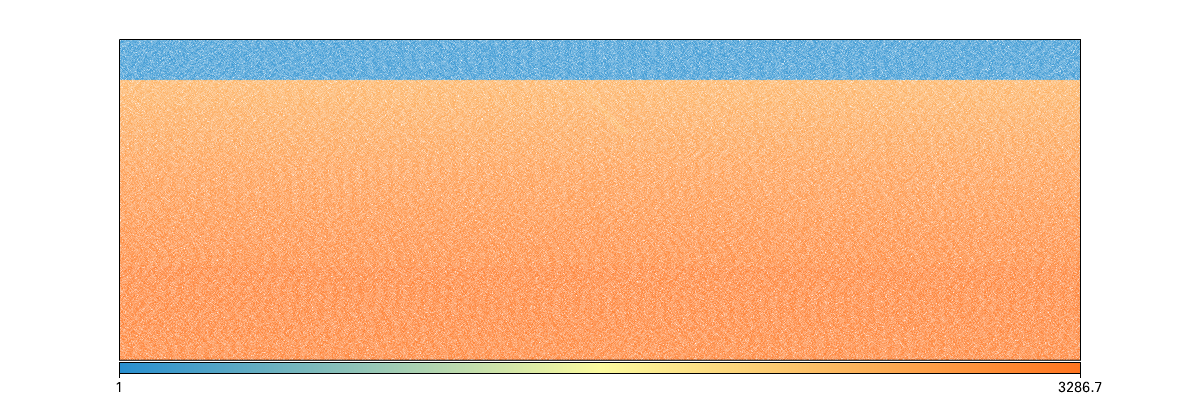

In [ ]:
FigDensity = glucifer.Figure(figsize=(1200,400))
FigDensity.Points(Model.swarm, GEO.dimensionalise(Model.densityField, u.kilogram / u.meter ** 3))
FigDensity.show()


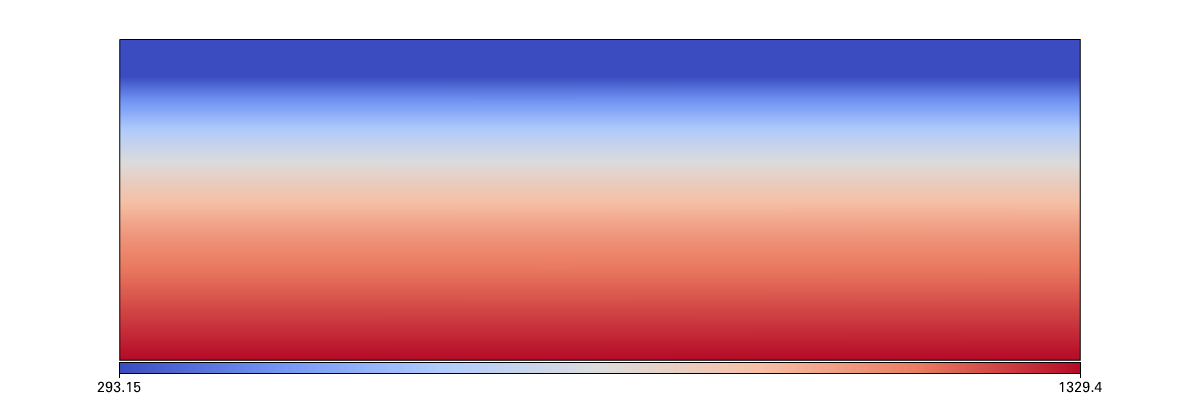

In [ ]:
FigTemp = glucifer.Figure(figsize=(1200,400))
FigTemp.Surface(Model.mesh, GEO.dimensionalise(Model.temperature, u.degK), colours="coolwarm")
FigTemp.show()


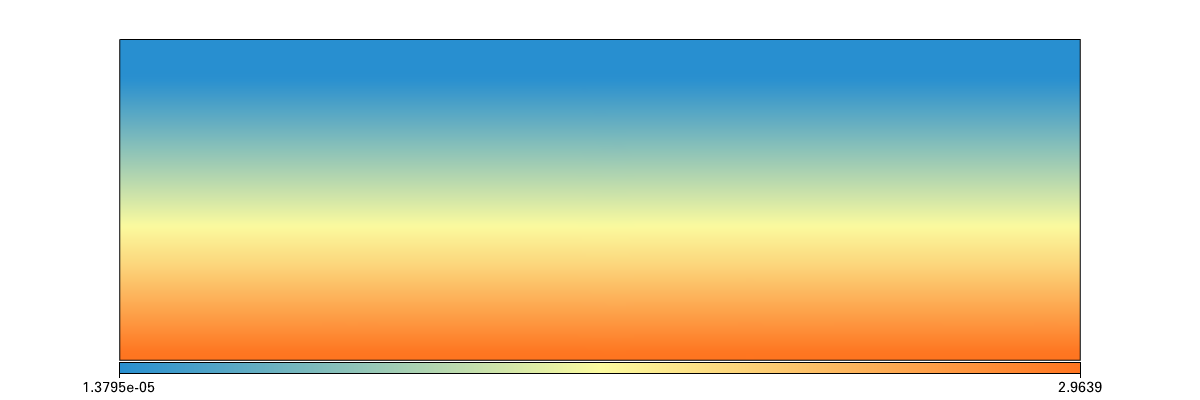

In [ ]:
FigPress = glucifer.Figure(figsize=(1200,400))
FigPress.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.gigapascal))
FigPress.show()


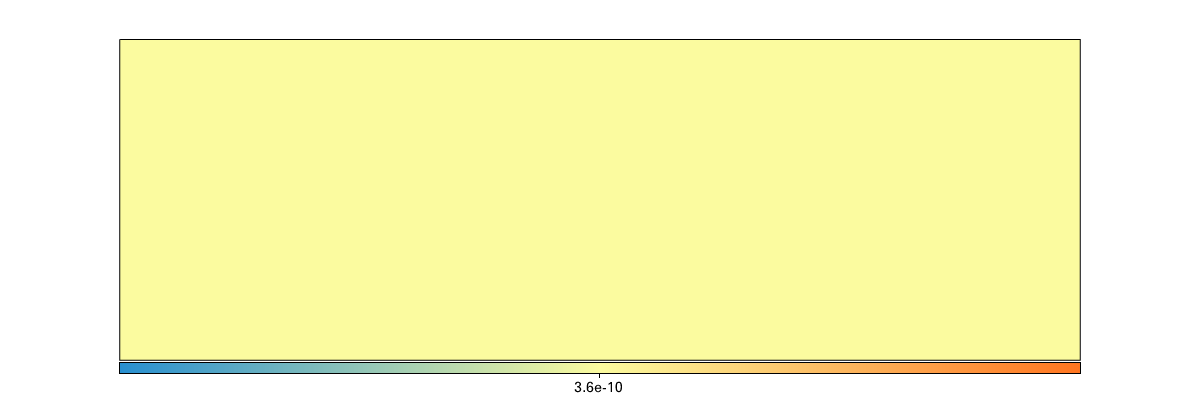

In [ ]:
FigPress = glucifer.Figure(figsize=(1200,400))
FigPress.Surface(Model.mesh, GEO.dimensionalise(Model.strainRateField, u.metre / u.second))
FigPress.show()

# Extract information

### Temperature at the Moho

<font color='red'>WARNING: The next cell is NOT PARALLEL SAFE and will results in an error if you try to run it on multiple CPUs. You MUST delete it before attempting to run the model in parallel. </font>

In [ ]:
if GEO.uw.mpi == 1:

    moho_average_temperature = Model.temperature.evaluate(moho_tracers.swarm).mean()
    moho_average_temperature = GEO.dimensionalise(moho_average_temperature, u.degC)

    print("Average Temperature at Moho: {0:5.0f}".format(moho_average_temperature))

In [ ]:
# if GEO.uw.nProcs() == 1:

#     moho_average_temperature = Model.temperature.evaluate(moho_tracers.swarm).mean()
#     moho_average_temperature = GEO.Dimensionalize(moho_average_temperature, u.degC)

#     print("Average Temperature at Moho: {0:5.0f}".format(moho_average_temperature))

<font color='red'>WARNING: The next cell is NOT PARALLEL SAFE and will results in an error if you try to run it on multiple CPUs. You MUST delete it before attempting to run the model in parallel. </font>

In [ ]:
#if GEO.uw.nProcs() == 1:
if GEO.uw.mpi == 1:
    import matplotlib.pyplot as plt

    distances, temperature = GEO.extract_profile(Model.temperature, line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])
    distances, pressure = GEO.extract_profile(Model.pressureField, line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])

    Fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))
    ax1.plot(GEO.dimensionalise(temperature, u.degK), GEO.dimensionalise(distances, u.kilometer))
    ax1.set_xlabel("Temperature in Kelvin")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(75, 0)
    ax1.set_title("Temperature profile")

    ax2.plot(GEO.dimensionalisedimensionalize(pressure, u.megapascal), GEO.dimensionalise(distances, u.kilometer))
    ax2.set_xlabel("Pressure in megapascal")
    ax2.set_ylabel("Depth in kms")
    ax2.set_title("Pressure profile")
    ax2.set_ylim(75, 0)
    plt.show()

## Visualise Solidus and Liquidus

<font color='red'>WARNING: The next cell is NOT PARALLEL SAFE and will results in an error if you try to run it on multiple CPUs. You MUST delete it before attempting to run the model in parallel. </font>

In [ ]:
#if GEO.uw.nProcs() == 1:
if GEO.uw.mpi == 1:
    T_s = my_crust_solidus.temperature(pressure)
    T_l = my_crust_liquidus.temperature(pressure)
    T_gs = mid_crust_solidus.temperature(pressure)
    T_gl = mid_crust_liquidus.temperature(pressure)
    depths = distances

    import pylab as plt

    fig = plt.figure(figsize=(8,4))
    plt.plot(GEO.dimensionalise(T_s, u.degC),GEO.dimensionalise(depths, u.kilometer), label="T_s")
    plt.plot(GEO.dimensionalise(T_l, u.degC),GEO.dimensionalise(depths, u.kilometer), label="T_l")
    plt.plot(GEO.dimensionalise(T_gs, u.degC),GEO.dimensionalise(depths, u.kilometer), label="T_gs")
    plt.plot(GEO.dimensionalise(T_gl, u.degC),GEO.dimensionalise(depths, u.kilometer), label="T_gl")
    plt.plot(GEO.dimensionalise(temperature, u.degC),GEO.dimensionaliseDimensionalize(depths, u.kilometer), label="Geotherm")
    plt.xlabel("Temperature (degC)")
    plt.ylabel("Depth (km)")
    plt.legend()
    plt.ylim(75, 0)
    plt.show()


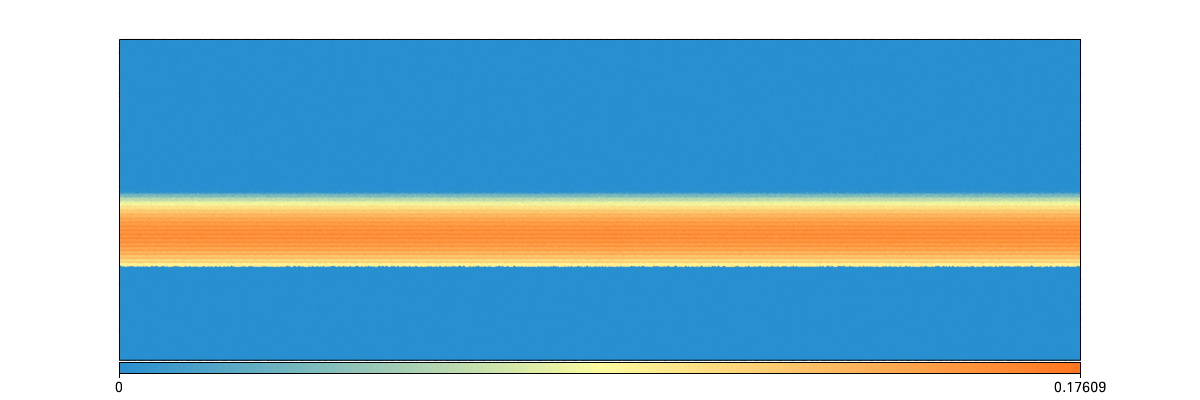

In [ ]:
Model.update_melt_fraction()
FigMelt = glucifer.Figure(figsize=(1200,400))
FigMelt.Points(Model.swarm, Model.meltField, fn_size=3.0)
FigMelt.show()

In [ ]:
#if GEO.uw.nProcs() == 1:
if GEO.uw.mpi == 1:
    distances, meltFraction = GEO.extract_profile(Model.projMeltField, 
                                                  line = [(180.* u.kilometer, 0.),
                                                          (180.* u.kilometer, Model.bottom)])

    Fig, ax1 = plt.subplots(1,1,figsize=(10,7))
    ax1.plot(meltFraction, GEO.dimensionalise(distances, u.kilometer))
    ax1.set_xlabel("Melt Fraction")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(75, 0)
    ax1.set_xlim(-0.1, 1.0)
    ax1.set_title("Melt Fraction")


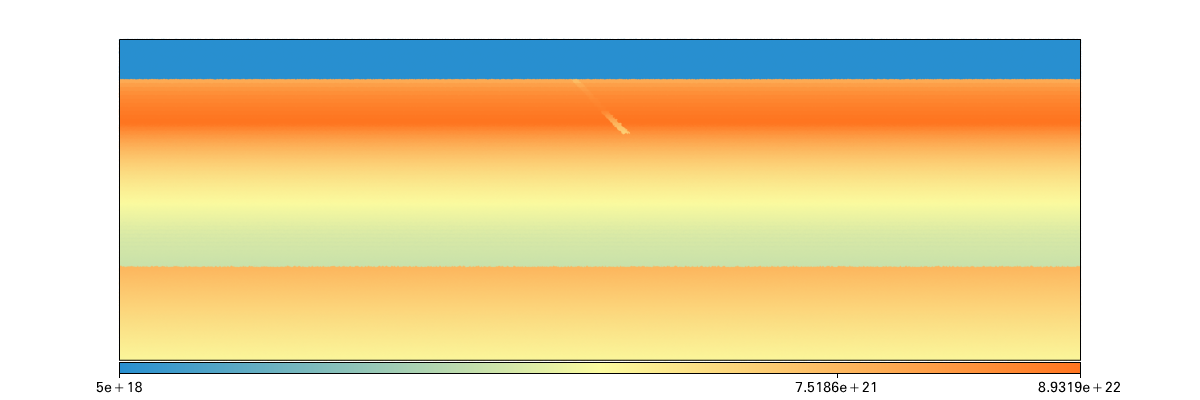

In [ ]:
FigVisc = glucifer.Figure(figsize=(1200,400))
FigVisc.Points(Model.swarm, GEO.dimensionalise(Model.viscosityField, u.pascal*u.second), fn_size=3.0, logScale=True)
FigVisc.show()

In [ ]:
#if GEO.uw.nProcs() == 1:
if GEO.uw.mpi == 1:
    distances, viscosities = GEO.extract_profile(Model.projViscosityField, 
                                                 line = [(180.* u.kilometer, 0.),
                                                         (180.* u.kilometer, Model.bottom)])

    Fig, ax1 = plt.subplots(1,1,figsize=(10,7))
    ax1.plot(GEO.dimensionalise(viscosities, u.pascal*u.second), GEO.dimensionalise(distances, u.kilometer))
    ax1.set_xscale("log")
    ax1.set_xlabel("Log Viscosity (Pa.s)")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(75, 0)
    ax1.set_xlim(1e16, 1e26)
    ax1.set_title("Viscosity Profile")

In [ ]:
solver = Model.solver

In [ ]:
# Decide whether to use mumps or multigrid
if resolution[0] * resolution[1] < 1e6:
    print("Using mumps")
    solver.set_inner_method("mumps")
else:
    print("Using multigrid with coarse mumps")
    #solver.options.mg.levels = 4
    solver.options.A11.mg_coarse_pc_factor_mat_solver_package = "mumps"
    solver.options.A11.mg_coarse_pc_type = "lu"
    solver.options.A11.mg_coarse_ksp_type = "preonly"
    #solver.options.A11.mg_coarse_ksp_view = ""

Using mumps


In [ ]:
# solver.options.main.remove_constant_pressure_null_space=True
Model.solver.set_penalty(1e6)

In [ ]:
#Model.run_for(200000000.* u.years, restartStep=99, restartDir= "outputs_script-G47301-Cenki-Tok-etal_test", checkpoint_interval=50000. * u.year)
Model.run_for(10000000.* u.years, checkpoint_interval=50000. * u.year)
#Model.run_for(nstep=2, checkpoint_interval = 1)

Running with UWGeodynamics version 2.8.5
Options:  -restore_K False -change_A11rhspresolve False -pc_type none -rescale_equations False -change_backsolve False -force_correction True -ksp_type bsscr -Q22_pc_type gkgdiag -remove_constant_pressure_null_space False -ksp_k2_type NULL -A11_ksp_type preonly -A11_pc_factor_mat_solver_type mumps -A11_pc_type lu -scr_ksp_rtol 1e-05 -scr_ksp_type fgmres -A11_mg_active False
Step:     1 Model Time: 35649.9 year dt: 35649.9 year (2020-02-27 00:25:37)
Step:     2 Model Time: 50000.0 year dt: 14350.1 year (2020-02-27 00:27:01)
Step:     3 Model Time: 85649.9 year dt: 35649.9 year (2020-02-27 00:27:38)
Step:     4 Model Time: 100000.0 year dt: 14350.1 year (2020-02-27 00:29:04)
Step:     5 Model Time: 135649.9 year dt: 35649.9 year (2020-02-27 00:29:42)
Step:     6 Model Time: 150000.0 year dt: 14350.1 year (2020-02-27 00:31:10)
Step:     7 Model Time: 185649.9 year dt: 35649.9 year (2020-02-27 00:31:47)
Step:     8 Model Time: 200000.0 year dt: 1435

Step:   103 Model Time: 2.6 megayear dt: 33280.7 year (2020-02-27 02:17:49)
Step:   104 Model Time: 2.6 megayear dt: 16719.3 year (2020-02-27 02:19:22)
Step:   105 Model Time: 2.6 megayear dt: 33948.6 year (2020-02-27 02:20:02)
Step:   106 Model Time: 2.7 megayear dt: 16051.4 year (2020-02-27 02:21:37)
Step:   107 Model Time: 2.7 megayear dt: 34397.7 year (2020-02-27 02:22:17)
Step:   108 Model Time: 2.7 megayear dt: 15602.3 year (2020-02-27 02:23:51)
Step:   109 Model Time: 2.7 megayear dt: 32644.8 year (2020-02-27 02:24:31)
Step:   110 Model Time: 2.8 megayear dt: 17355.2 year (2020-02-27 02:26:05)
Step:   111 Model Time: 2.8 megayear dt: 35649.9 year (2020-02-27 02:26:45)
Step:   112 Model Time: 2.8 megayear dt: 14350.1 year (2020-02-27 02:28:19)
Step:   113 Model Time: 2.8 megayear dt: 34382.6 year (2020-02-27 02:28:59)
Step:   114 Model Time: 2.9 megayear dt: 15617.4 year (2020-02-27 02:30:32)
Step:   115 Model Time: 2.9 megayear dt: 35146.9 year (2020-02-27 02:31:12)
Step:   116 